In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile("../content/drive/MyDrive/test.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../content/drive/MyDrive/train.zip","r") as z:
    z.extractall(".")

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression

from glob import glob
import scipy
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from scipy.fftpack import fft, ifft
import os

from sklearn.preprocessing import StandardScaler

def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
#############function to read data###########

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels
def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep
subjects = range(1,6)

In [4]:
from glob import glob
import pandas as pd
ids_tot = []
pred_tot = []
X_train_butter = []
from sklearn.model_selection import train_test_split
import numpy as  np

###loop on subjects and 8 series for train data + 2 series for test data
y_raw= []
raw = []
y_rawt= []
rawt = []
for subject in subjects:
    
    ################ READ DATA ################################################
    fnames =  sorted(glob('train/subj%d_series*_data.csv' % (subject)))


#    fnames =  glob('../input/train/subj1_series1_events.csv')
#    fnames =  glob('../input/train/subj1_series1_data.csv')
    for fname in fnames:
      data,labels=prepare_data_train(fname)
      raw.append(data)
      y_raw.append(labels)

    for fname in fnames:
      with open(fname) as myfile:
        head = [next(myfile) for x in range(10)]
        

      
        
X = pd.concat(raw)
y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
X_train =np.asarray(X.astype(float))
y_train = np.asarray(y.astype(float))
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
fs = 500.0
lowcut = 7.0
highcut = 30.0


x_train_butter=wavelet_denoising(X_train)
x_train=data_preprocess_train(x_train_butter)
splitrate=-x_train.shape[0]//5*2
xval=x_train[splitrate:splitrate//2]
yval=y_train[splitrate:splitrate//2]
xtest=x_train[splitrate//2:]
ytest=y_train[splitrate//2:]
xtrain=x_train[:splitrate]
ytrain=y_train[:splitrate]

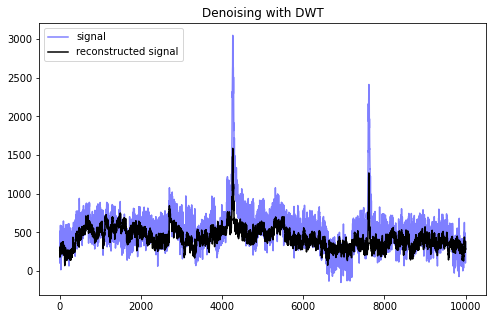

In [5]:
import pywt
import pandas as pd
import numpy as np
def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

signal=pd.read_csv('train/subj1_series1_data.csv')
signal = signal.drop("id", axis=1)
filtered = wavelet_denoising(signal, wavelet='db2', level=3)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(signal.iloc[:10000,1], label='signal', color="b", alpha=0.5,)
ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
ax.legend(loc='upper left')
ax.set_title('Denoising with DWT')
plt.show()

In [ ]:
import seaborn as sns
ye=pd.DataFrame(y_train)

ye.columns=["Handstart ","Grasping ","Lift ","Hold ","Replace ","Release"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout, Activation
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf

#from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
# from keras import optimizers
# from keras import regularizers
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.utils import plot_model

In [ ]:
time_steps = 1000
subsample = 10
model3 = Sequential()
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(6, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0001), metrics=['accuracy'])
model3.summary()

In [ ]:
class Attention(Layer):

    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [ ]:

    input_words = Input((maxlen, ))
    x_words = Embedding(vocab_size,
                        embedding_size,
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False)(input_words)
    x_words = SpatialDropout1D(0.3)(x_words)
    x_words = Bidirectional(LSTM(50, return_sequences=True))(x_words)
    x = Attention(maxlen)(x_words)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(target_count, activation='softmax')(x)

    model = Model(inputs=input_words, outputs=pred)
    return model

model = build_model(maxlen, vocab_size, embedding_size, embedding_matrix)
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
def valgenerator():
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [ ]:
import time
start=time.time()
def generator(batch_size):
    while 1:
        
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

history =model.fit_generator(generator(32), steps_per_epoch = 200, epochs = 50,validation_data=valgenerator(), validation_steps=100)
print('training time taken: ',round(time.time()-start,0),'seconds')